# Citations to the top cited

We are interested in studying the pattern of citing the super-cited in terms of gender.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import networkx as nx
import numpy as np

### Citation table

We take cites from 1990 to 2019 avoiding self-cites.

In [2]:
cite = pd.read_csv("../data/processed/cites.csv")

cite = cite[(cite.t_year >= 1990) & (cite.t_year < 2020)]
cite = cite[(cite.s_year >= 1990) & (cite.s_year < 2020)]

cite = cite[cite.target != cite.source]

### Authors table

There are two author tables: 

1. One with the comparable groups A and B (`people`) and 
2. the one with the all the authors found in the RePEc repository (`all_people`).

In [3]:
people = pd.read_csv("../data/processed/network_people.csv")
all_people = pd.read_csv("../data/processed/people.csv")

### Places table

We use the institution to infer the place of work of the authors. We have:

1. The region (continent)
2. The sub-region (sub-continent)
3. Country 3-letter code
4. The institution's name

In [4]:
places = pd.read_csv("../data/processed/institution.csv")

places = places[['Handle', 'Primary-Name', 'alpha-3', 'region', 'sub-region']].set_index("Handle")

### Adding place of work to people

In [5]:
all_people = pd.merge(all_people,
                  places,
                  left_on="Workplace-Institution",
                  right_index=True,
                  how="left")

# all_people = all_people[all_people.region.notna()]

### Adding gender to the citation table

We have two genders for each cite:

1. Gender of the source (`gender_s`)
3. Gender of the target (`gender`)

In [6]:
cite = pd.merge(cite,
                all_people[["Short-Id", "gender"]],
                how="left",
                left_on="target",
                right_on="Short-Id")

cite = pd.merge(cite,
                all_people[["Short-Id", "gender"]].rename(columns={"gender":"gender_s"}),
                how="left",
                left_on="source",
                right_on="Short-Id")

Let's remove the citations without the gender of the target from the table.

In [7]:
cite = cite[cite.gender.notna()]
cite = cite[cite.gender_s.notna()]

## Super-cited researchers

Let's get some basic statistics of the super-cited researchers in our citation network.

In [8]:
G = nx.from_pandas_edgelist(cite,
                            source='source',
                            target='target',
                            create_using=nx.DiGraph)

In [9]:
len(G)

36665

In [10]:
degree = pd.DataFrame(G.in_degree(), columns=["author", "degree"])
mu = degree.degree.mean()
r = degree.degree.quantile(.75) - degree.degree.quantile(.25)

In [11]:
super_cited = degree[degree.degree >= mu + 1.5 * r].author.unique()
cite_sc = cite[cite.target.isin(super_cited)]

### Proportion of gender by group

In [12]:
len(G)

36665

In [13]:
all_people[all_people['Short-Id'].isin(list(G))].gender.value_counts(normalize=True)

male      0.762662
female    0.237338
Name: gender, dtype: float64

In [14]:
people.groupby('group').size()

group
A    7942
B    1388
dtype: int64

In [15]:
len(super_cited)

4111

In [16]:
len(super_cited) / degree.author.nunique()

0.11212327833083321

In [17]:
all_people[all_people['Short-Id'].isin(super_cited)].gender.value_counts(normalize=True)

male      0.877645
female    0.122355
Name: gender, dtype: float64

In [18]:
all_people[(all_people['Short-Id'].isin(list(G)))].gender.value_counts(normalize=True)

male      0.762662
female    0.237338
Name: gender, dtype: float64

In [19]:
people.groupby('group').size()

group
A    7942
B    1388
dtype: int64

In [20]:
people.groupby('group').gender.value_counts(normalize=True)

group  gender
A      female    0.5
       male      0.5
B      female    0.5
       male      0.5
Name: gender, dtype: float64

### Cites by gender

Let's look at how female and male researchers cite other female and male researchers depending on the group.

In [21]:
cite.shape

(3573514, 11)

In [22]:
cite.gender.value_counts(normalize=True)

male      0.87594
female    0.12406
Name: gender, dtype: float64

In [23]:
cite[cite.target.isin(people[people.group=='A']['Short-Id'])].gender.value_counts(normalize=True)

female    0.501113
male      0.498887
Name: gender, dtype: float64

In [24]:
cite[cite.target.isin(people[people.group=='B']['Short-Id'])].gender.value_counts(normalize=True)

female    0.504776
male      0.495224
Name: gender, dtype: float64

In [25]:
cite[cite.target.isin(super_cited)].gender.value_counts(normalize=True)

male      0.904997
female    0.095003
Name: gender, dtype: float64

In [26]:
cite.gender_s.value_counts(normalize=True)

male      0.83079
female    0.16921
Name: gender_s, dtype: float64

In [27]:
cite[cite.source.isin(people[people.group=='A']['Short-Id'])].gender_s.value_counts(normalize=True)

male      0.5272
female    0.4728
Name: gender_s, dtype: float64

In [28]:
cite[cite.source.isin(people[people.group=='B']['Short-Id'])].gender_s.value_counts(normalize=True)

male      0.51902
female    0.48098
Name: gender_s, dtype: float64

In [29]:
cite[cite.source.isin(super_cited)].gender_s.value_counts().sum()

1229395

### Cites from genders to groups

In [30]:
cite[cite.gender_s=="female"].gender.value_counts(normalize=True)

male      0.847983
female    0.152017
Name: gender, dtype: float64

In [31]:
cite[cite.gender=="female"].gender_s.value_counts(normalize=True)

male      0.792657
female    0.207343
Name: gender_s, dtype: float64

In [32]:
cite.groupby('gender').gender_s.value_counts(normalize=True)

gender  gender_s
female  male        0.792657
        female      0.207343
male    male        0.836190
        female      0.163810
Name: gender_s, dtype: float64

In [33]:
cite.groupby('gender_s').gender.value_counts(normalize=True)

gender_s  gender
female    male      0.847983
          female    0.152017
male      male      0.881634
          female    0.118366
Name: gender, dtype: float64

In [34]:
cite[cite.target.isin(people[people.group=='A']['Short-Id'])].groupby('gender_s').gender.value_counts(normalize=True)

gender_s  gender
female    female    0.558899
          male      0.441101
male      male      0.513417
          female    0.486583
Name: gender, dtype: float64

In [35]:
cite[cite.target.isin(people[people.group=='B']['Short-Id'])].groupby('gender_s').gender.value_counts(normalize=True)

gender_s  gender
female    female    0.554278
          male      0.445722
male      male      0.506481
          female    0.493519
Name: gender, dtype: float64

In [36]:
cite[cite.target.isin(super_cited)].groupby('gender_s').gender.value_counts(normalize=True)

gender_s  gender
female    male      0.884133
          female    0.115867
male      male      0.909172
          female    0.090828
Name: gender, dtype: float64

### Cites from genders to groups

In [37]:
cite.groupby('gender').gender_s.value_counts(normalize=True)

gender  gender_s
female  male        0.792657
        female      0.207343
male    male        0.836190
        female      0.163810
Name: gender_s, dtype: float64

In [38]:
cite[cite.source.isin(people[people.group=='A']['Short-Id'])].groupby('gender').gender_s.value_counts(normalize=True)

gender  gender_s
female  female      0.530496
        male        0.469504
male    male        0.536611
        female      0.463389
Name: gender_s, dtype: float64

In [39]:
cite[cite.source.isin(people[people.group=='B']['Short-Id'])].groupby('gender').gender_s.value_counts(normalize=True)

gender  gender_s
female  female      0.535203
        male        0.464797
male    male        0.527014
        female      0.472986
Name: gender_s, dtype: float64

In [40]:
cite[cite.source.isin(super_cited)].groupby('gender').gender_s.value_counts(normalize=True)

gender  gender_s
female  male        0.878215
        female      0.121785
male    male        0.906553
        female      0.093447
Name: gender_s, dtype: float64

## Yearly analysis

We create yearly sub-graphs (`graphps`) using the citation table to be able to look at the evolution of the cites.

In [41]:
cite['gender'].value_counts(normalize=True)

male      0.87594
female    0.12406
Name: gender, dtype: float64

In [42]:
cite[cite.s_year==2011].groupby('gender_s')['gender'].value_counts(normalize=True)

gender_s  gender
female    male      0.853360
          female    0.146640
male      male      0.884609
          female    0.115391
Name: gender, dtype: float64

In [43]:
graphs = []
years = []
for year in [2000, 2003] + list(range(2005, 2020)):
    years.append(year)
    if year == 2000:
        chunk = cite[cite.s_year <= year]
    elif year == 2003:
        chunk = cite[(cite.s_year > 2000) & (cite.s_year <= 2003)]
    elif year == 2005:
        chunk = cite[(cite.s_year > 2003) & (cite.s_year <= 2005)]
    else:
        chunk = cite[cite.s_year == year]
    G = nx.from_pandas_edgelist(chunk,
                                source="source",
                                target="target",
                                create_using=nx.DiGraph)
    G.remove_edges_from(nx.selfloop_edges(G))
    graphs.append(G)

In [44]:
outliers = []
edges = []
edges_out = []
nodes = []
for g in graphs:
    degree = pd.DataFrame(g.in_degree,
                         columns=['a', 'd'])
    mu = degree['d'].mean()
    iqr = (degree['d'].quantile(.75) - degree['d'].quantile(.25))
    outs = list(degree[degree.d >= mu + 1.5 * iqr].a)
    outliers.append(outs)
    edges.append(degree.d.sum())
    edges_out.append(degree[degree.a.isin(outs)].d.sum())
    nodes.append(len(g))

In [76]:
female = []
cite_male = []
cite_female = []
for i, year in enumerate([2000, 2003] + list(range(2005, 2020))):
    if year == 2000:
        chunk = cite[(cite.s_year <= year) & (cite.target.isin(outliers[i]))]
    elif year == 2003:
        chunk = cite[(cite.s_year > 2000) & (cite.s_year <= 2003) & (cite.target.isin(outliers[i]))]
    elif year == 2005:
        chunk = cite[(cite.s_year > 2003) & (cite.s_year <= 2005) & (cite.target.isin(outliers[i]))]
    else:
        chunk = cite[(cite.s_year == year) & (cite.target.isin(outliers[i]))]
    genders = chunk.gender.value_counts(normalize=True)
    female.append(genders.loc["female"])
    from_male = chunk[chunk.gender_s=='male']['gender'].value_counts(normalize=True).iloc[1]
    from_female = chunk[chunk.gender_s=='female']['gender'].value_counts(normalize=True).iloc[1]
    cite_male.append(from_male)
    cite_female.append(from_female)

In [77]:
years_str = [str(y) for y in years]

In [78]:
df = pd.DataFrame({"male": cite_male, "female": cite_female, "prop": female, "Year": years_str})

df['male'] = (df['male'] - df['prop']) / df['prop']
df['female'] = (df['female'] - df['prop']) / df['prop']
df = df.drop('prop', axis=1)

df_melt = pd.melt(df, var_name="Gender", value_name="Bias", id_vars='Year')

In [79]:
df_melt.to_csv('../data/bias_super_cited.csv', index=False)

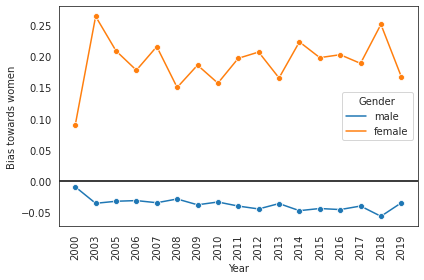

In [80]:
# fig, ax = plt.subplots(figsize=(11, 6))
with sns.axes_style('white'):
    sns.lineplot(x="Year", y="Bias", hue="Gender", data=df_melt, marker="o")
plt.axhline(0, color="black")
plt.ylabel("Bias towards women")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../figures/bias_super-cited.png", dpi=300)

In [81]:
female = []
cite_male = []
cite_female = []
for i, year in enumerate([2000, 2003] + list(range(2005, 2020))):
    if year == 2000:
        chunk = cite[(cite.s_year <= year)]
    elif year == 2003:
        chunk = cite[(cite.s_year > 2000) & (cite.s_year <= 2003)]
    elif year == 2005:
        chunk = cite[(cite.s_year > 2003) & (cite.s_year <= 2005)]
    else:
        chunk = cite[(cite.s_year == year)]
    genders = chunk.gender.value_counts(normalize=True)
    female.append(genders.loc["female"])
    from_male = chunk[chunk.gender_s=='male']['gender'].value_counts(normalize=True).iloc[1]
    from_female = chunk[chunk.gender_s=='female']['gender'].value_counts(normalize=True).iloc[1]
    cite_male.append(from_male)
    cite_female.append(from_female)

In [82]:
years_str = [str(y) for y in years]

In [83]:
df = pd.DataFrame({"male": cite_male, "female": cite_female, "prop": female, "Year": years_str})

df['male'] = (df['male'] - df['prop']) / df['prop']
df['female'] = (df['female'] - df['prop']) / df['prop']
df = df.drop('prop', axis=1)

df_melt = pd.melt(df, var_name="Gender", value_name="Bias", id_vars='Year')

In [84]:
df_melt.to_csv('../data/bias.csv', index=False)

In [54]:
cite[(cite.gender_s=='male') & (cite.target.isin(people[people.group=='B']["Short-Id"].values))]['gender'].value_counts(normalize=True)

male      0.506481
female    0.493519
Name: gender, dtype: float64

In [55]:
cite[(cite.gender_s=='male') & (cite.target.isin(people[people.group=='A']["Short-Id"].values))]['gender'].value_counts(normalize=True)

male      0.513417
female    0.486583
Name: gender, dtype: float64

In [56]:
cite[(cite.gender_s=='female') & (cite.target.isin(people[people.group=='A']["Short-Id"].values))]['gender'].value_counts(normalize=True)

female    0.558899
male      0.441101
Name: gender, dtype: float64

In [57]:
cite[(cite.gender_s=='female') & (cite.target.isin(people[people.group=='B']["Short-Id"].values))]['gender'].value_counts(normalize=True)

female    0.554278
male      0.445722
Name: gender, dtype: float64

In [58]:
cite.gender_s.value_counts(normalize=True)

male      0.83079
female    0.16921
Name: gender_s, dtype: float64

In [59]:
all_people[all_people['Short-Id'].isin(cite.target.unique())].gender.value_counts(normalize=True)

male      0.769861
female    0.230139
Name: gender, dtype: float64